# train 1D ML model for more realistic potential at solar radius

In [272]:
import torch
import orbitflows as of
from orbitflows import HamiltonianMappingModel, MWPotential2014, SymplecticCouplingLayer, SimpleNNConditioner, GradientBasedConditioner, H, scaled_H_std, NFWPotential, MiyamotoNagaiPotential
import matplotlib.pyplot as plt
from functools import partial
from astropy import units as u
torch.set_default_dtype(torch.float64)

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['font.size'] = 12.5
plt.rcParams['axes.labelsize'] = 14
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "stix"

In [9]:
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014 as galpy_MW14
from galpy.potential import vcirc, verticalfreq

In [10]:
ro = 8.0 * u.kpc
vo = 220.0 * u.km / u.s

In [11]:
zlist = torch.linspace(-1.0, 1.0, 100) / ro.value

## Setup model

In [34]:
def isoDiskPotential(x, amp=1, sigma=0.1):
    _H = sigma / torch.sqrt(torch.tensor([8.0 * torch.pi * amp]))[0]
    _sigma2 = sigma**2
    return 2.0 * _sigma2 * torch.log(torch.cosh(0.5 * x / _H))

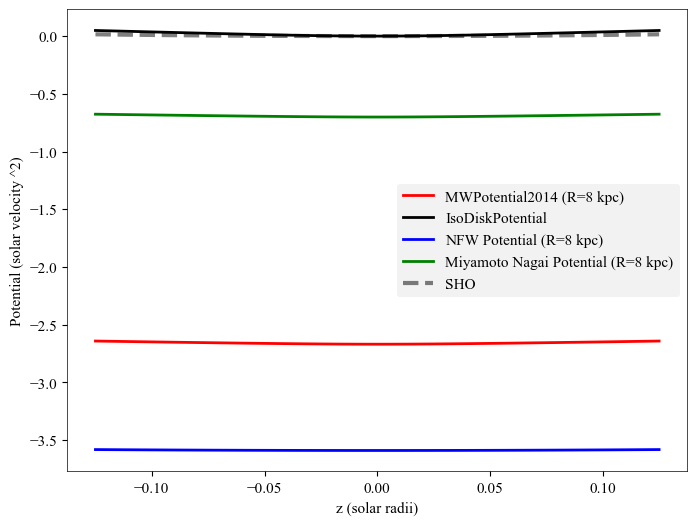

In [35]:
omega = 1 # verticalfreq(galpy_MW14,8 * u.kpc) / (2 * torch.pi)
MW14_1D = partial(MWPotential2014, R=1.0)#(zlist/ro.value)
# offset = torch.min(potential_values)
# MW14_1D = lambda z : partial(MWPotential2014, R=1.0)(z) #- offset # define 1D potential

NFW_1D = partial(NFWPotential, R=1.0)#(zlist/ro.value)
# offset_nfw = torch.min(nfw_values)
# NFW_1D = lambda z : partial(NFWPotential, R=1.0)(z) #- offset_nfw

MN_1D = partial(MiyamotoNagaiPotential, R=1.0)#(zlist/ro.value)
# offset_mn = torch.min(mn_values)
# MN_1D = lambda z : partial(MiyamotoNagaiPotential, R=1.0)(z) #- offset_mn


plt.figure(figsize=(8, 6))
plt.plot(zlist, MW14_1D(zlist), c='r', label='MWPotential2014 (R=8 kpc)', lw=2)
plt.plot(zlist, isoDiskPotential(zlist), c='k', linestyle='-', lw=2, alpha=1, label='IsoDiskPotential')
plt.plot(zlist, NFW_1D(zlist), c='b', linestyle='-', lw=2, alpha=1, label='NFW Potential (R=8 kpc)')
plt.plot(zlist, MN_1D(zlist), c='green', linestyle='-', lw=2, alpha=1, label='Miyamoto Nagai Potential (R=8 kpc)')
plt.plot(zlist, (omega * zlist)**2, label='SHO', linestyle='--', lw=3, alpha=0.5)
plt.xlabel('z (solar radii)')
plt.ylabel('Potential (solar velocity ^2)')
plt.legend()

In [134]:
# initialize model
omega0 = 2 #verticalfreq(galpy_MW14,1.0) #/ (2 * torch.pi)
model = HamiltonianMappingModel(
    targetPotential=MW14_1D,
    omega=omega0,
    input_dim=2, 
    num_layers=32,
    layer_class=SymplecticCouplingLayer,
    conditioner=GradientBasedConditioner
    # conditioner_args={
    #     'num_layers' : 2,
    #     'projection_dims' : 64,}
    )
model.flow = model.flow.double()

In [135]:
model.flow

Flow(
  (layers): ModuleList(
    (0-31): 32 x SymplecticCouplingLayer(
      (conditioner): GradientBasedConditioner()
    )
  )
)

## Training Set

In [136]:
(50 * vo.unit) / vo

<Quantity 0.22727273>

In [137]:
0.15 * vo

<Quantity 33. km / s>

Text(0, 0.5, 'energy')

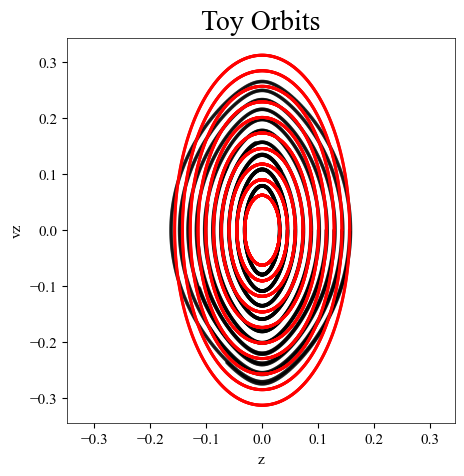

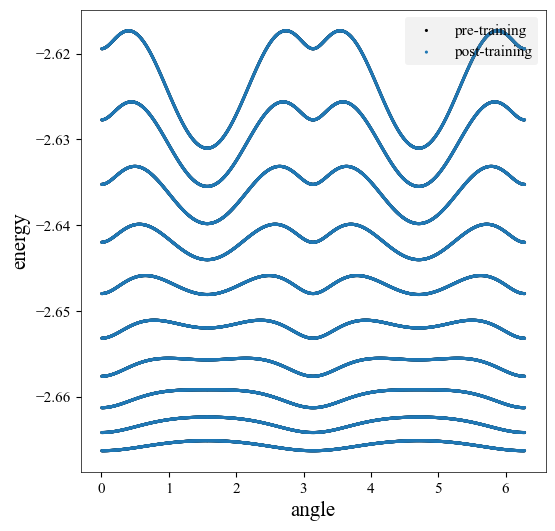

In [138]:
from galpy.potential import verticalfreq
import numpy as np

n_actions = 10
n_angles = 1000
training_ps, training_aa = of.generate_sho_orbits(num_orbits=n_actions, omega=omega0, t_end = 2*torch.pi / omega0, n_steps=n_angles, r_bounds=torch.tensor([0.25, 1.25])/ro.value)
training_aa = training_aa.to(torch.float64)

galpy_orbits = Orbit([[1.0, 0.0, 1.0, z_i ,0.0, 0.0] for z_i in training_ps[...,0][...,0]])#[R,vR,vT(,z,vz,phi)]
tlist = np.linspace(0, 2*verticalfreq(galpy_MW14, 1.0), 1000)
galpy_orbits.integrate(t=tlist, pot=galpy_MW14)


plt.figure(figsize=(5, 5))
plt.scatter(galpy_orbits.z(tlist), galpy_orbits.vz(tlist), c='k', s=7, alpha=0.5)
plt.scatter(*training_ps.T, s=5, c='r')

plt.axis('equal')
plt.xlabel('z')
plt.ylabel('vz')
plt.title('Toy Orbits', fontsize=20)

plt.figure(figsize=(6, 6))
plt.scatter(training_aa[...,0], H(training_ps, model.targetPotential).detach(), s=5, label='pre-training')
plt.scatter(training_aa[...,0], model.hamiltonian(training_aa).detach(), s=5, label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)

In [139]:
def smoothing_term(ps, targetPotential):
    '''loss term that enforces smoothness by quantifying how much nearby points differ'''
    return torch.diff(H(ps, targetPotential), dim=-1).abs().std() + torch.diff(H(ps, targetPotential), dim=-1).abs().mean() 

def smooth_flat_H(ps, targetPotential, smoothing_term=smoothing_term, smoothing_amp=0.1):
    '''loss term that enforces smoothness by quantifying how much nearby points differ'''
    return (scaled_H_std(ps, targetPotential) + smoothing_amp * smoothing_term(ps, targetPotential))

In [140]:
torch.autograd.set_detect_anomaly(True)

100%|██████████| 1000/1000 [02:33<00:00,  6.51it/s]


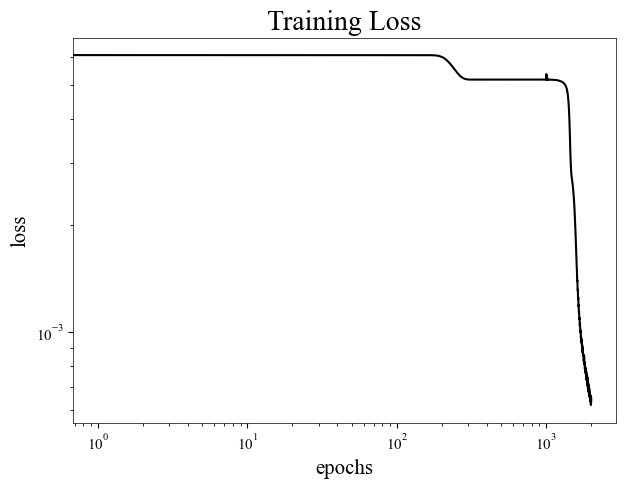

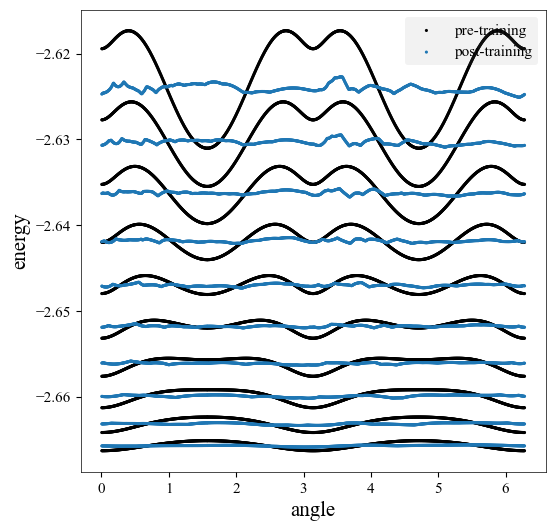

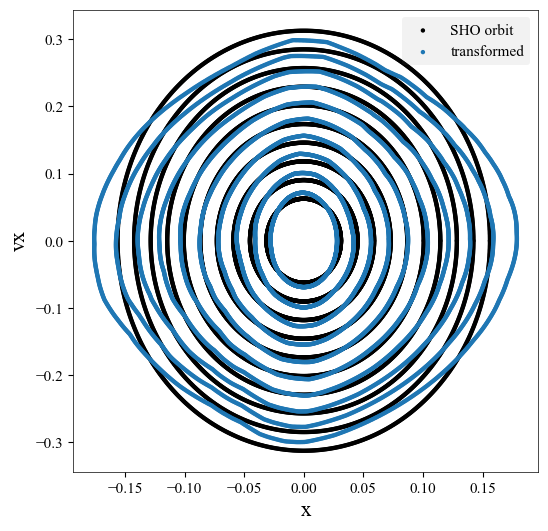

In [ ]:
# train model
steps = 1000
model.train(training_ps, steps, lr=1e-3)#, loss_function=smooth_flat_H, lf_args={'targetPotential': model.targetPotential, 'smoothing_amp':1.5e3})

# plot loss
plt.figure(figsize=(7, 5))
plt.loglog(model.loss_list)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.title('Training Loss', fontsize=20)
plt.show()

# # plot performance for one orbit
# plt.figure(figsize=(8, 5))
# plt.plot(aa_guess[0][...,0].detach(), model.hamiltonian(aa_guess[0]).detach())
# plt.plot(aa_guess[0][...,0].detach(), np.repeat(model.hamiltonian(aa_guess[0]).mean().detach(), len(aa_guess[0][...,0].detach())), 'r--')
# plt.xlabel('time', fontsize=15)
# plt.ylabel('energy', fontsize=15)
# plt.title('model performance', fontsize=20)
# plt.show()
plt.figure(figsize=(6, 6))
plt.scatter(training_aa[...,0], H(training_ps, model.targetPotential).detach(), s=5, label='pre-training')
plt.scatter(training_aa[...,0], model.hamiltonian(training_aa).detach(), s=5, label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)
plt.show()

# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(6,6))
plt.scatter(training_ps.T[0] * ro, training_ps.T[1] * vo, s=10, label='SHO orbit')
plt.scatter(model.flow(training_ps).T.detach()[0]*ro, model.flow(training_ps).T.detach()[1]*vo, s=10, label='transformed')
plt.xlabel('z [kpc', fontsize=15)
plt.ylabel('v$_z$ [km/s]', fontsize=15)
plt.legend()
plt.show()

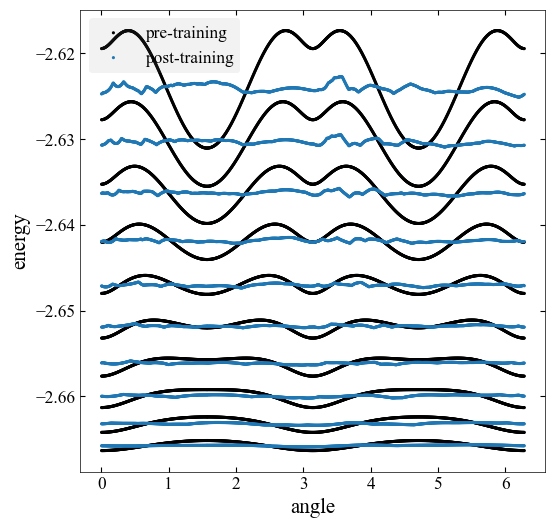

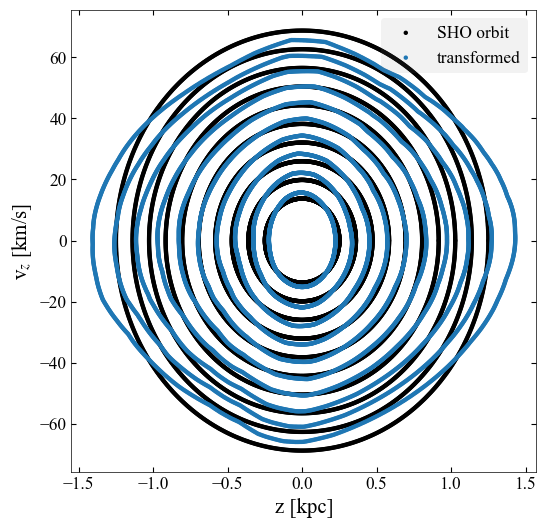

In [276]:
plt.figure(figsize=(6, 6))
plt.scatter(training_aa[...,0], H(training_ps, model.targetPotential).detach(), s=5, label='pre-training')
plt.scatter(training_aa[...,0], model.hamiltonian(training_aa).detach(), s=5, label='post-training')
plt.legend()
plt.xlabel('angle', fontsize=15)
plt.ylabel('energy', fontsize=15)
plt.show()

# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(6,6))
plt.scatter(training_ps.T[0] * ro, training_ps.T[1] * vo, s=10, label='SHO orbit')
plt.scatter(model.flow(training_ps).T.detach()[0]*ro, model.flow(training_ps).T.detach()[1]*vo, s=10, label='transformed')
plt.xlabel('z [kpc]', fontsize=15)
plt.ylabel('v$_z$ [km/s]', fontsize=15)
plt.legend()
plt.show()

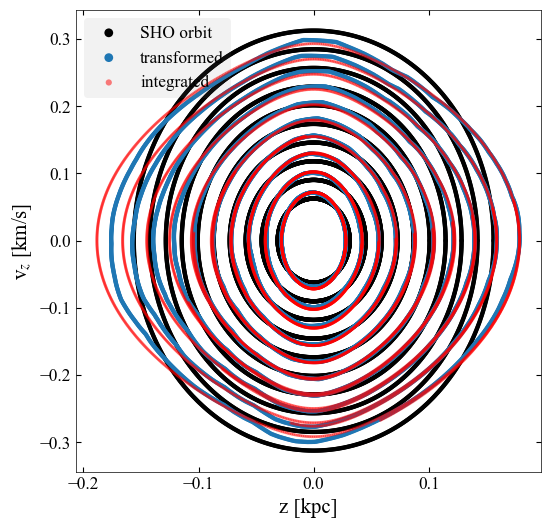

In [277]:
galpy_orbits_2 = Orbit([[1.0, 0.0, 1.0, z_i , vz_i, 0.0] for (z_i, vz_i) in zip(model.flow(training_ps)[...,0][...,0].detach().numpy(),  model.flow(training_ps)[...,1][...,0].detach().numpy())])#[R,vR,vT(,z,vz,phi)]
tlist = np.linspace(0, 2*verticalfreq(galpy_MW14, 1.0), 1000)
galpy_orbits_2.integrate(t=tlist, pot=galpy_MW14)

plt.figure(figsize=(6,6))
plt.scatter(*training_ps.T, s=10, label='SHO orbit')
plt.scatter(*model.flow(training_ps).T.detach(), s=10, label='transformed')
plt.scatter(galpy_orbits_2.z(tlist), galpy_orbits_2.vz(tlist), c='r', s=5, alpha=0.5, label='integrated')
plt.xlabel('z [kpc]', fontsize=15)
plt.ylabel('v$_z$ [km/s]', fontsize=15)
plt.legend(markerscale=2)
plt.show()

# Compare with Adiabatic Approximation

In [278]:
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleAdiabatic
aAA= actionAngleAdiabatic(pot=MWPotential2014, c=True)

In [279]:
aAA(1.,0.1,1.1,0.,0.05)
# (0.01351896260559274, 1.1, 0.0004690133479435352)

(array([0.01352523]), array([1.1]), array([0.00046909]))

In [280]:
range(len(tlist)-1)

range(0, 999)

In [285]:
js = np.zeros((n_actions, 3, len(tlist)))
for i in range(n_actions):
    js[i] = aAA(galpy_orbits_2.R(tlist)[i], galpy_orbits_2.vR(tlist)[i], galpy_orbits_2.vT(tlist)[i], galpy_orbits_2.z(tlist)[i], galpy_orbits_2.vz(tlist)[i])
jrs = js[:,-1]

In [286]:
ic = torch.tensor([galpy_orbits_2.z(tlist), galpy_orbits_2.vz(tlist)]).requires_grad_(True)

In [290]:
nf_jrs = model.ps_to_aa(ic.T)[...,-1].T

Text(0, 0.5, '$J_z$')

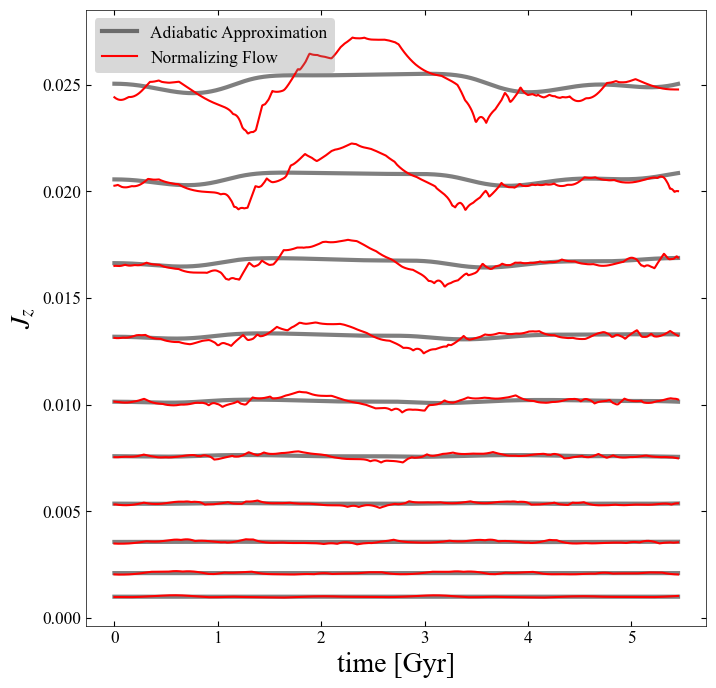

In [306]:
plt.figure(figsize=(8, 8))  
plt.plot(tlist, jrs.T[:, 1:], c='k', lw=3, alpha=0.5)
plt.plot(tlist, jrs.T[:, 0], c='k', lw=3, alpha=0.5, label='Adiabatic Approximation')

plt.plot(tlist, nf_jrs.T.detach()[:,1:], c='r')
plt.plot(tlist, nf_jrs.T.detach()[:,0], c='r', label='Normalizing Flow')
#plt.plot(tlist, tlist, c='r')

plt.legend(framealpha=0.3, loc='upper left')
plt.xlabel('time [Gyr]', fontsize=20)
plt.ylabel('$J_z$', fontsize=20)

In [312]:
nf_jrs[::3].T.shape

torch.Size([1000, 4])

In [329]:
n_actions//2

5

In [336]:
jrs.T[0].min()

np.float64(0.0009912549286064365)

In [349]:
jrs.T[0][::3]

array([0.00099125, 0.00535583, 0.0131837 , 0.02504943])

In [394]:
cmap(np.linspace(0, n_actions))

array([[0.10588235, 0.61960784, 0.46666667, 1.        ],
       [0.85098039, 0.37254902, 0.00784314, 1.        ],
       [0.90588235, 0.16078431, 0.54117647, 1.        ],
       [0.4       , 0.65098039, 0.11764706, 1.        ],
       [0.65098039, 0.4627451 , 0.11372549, 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       , 0.4       , 1.        ],
       [0.4       , 0.4       ,

In [395]:
from matplotlib.colors import ListedColormap

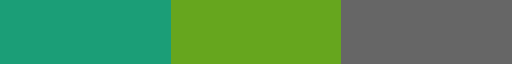

In [400]:
cmap

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_3796/2731937390.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = ListedColormap(cm.get_cmap('Dark2')(np.linspace(0, 0.25, n_actions//3)))

/var/folders/s1/bxkg8f1501g2q16qjhch2_qw0000gn/T/ipykernel_3796/2731937390.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f'{i:.3f}' for i in jrs.T[0][::3]])



Text(0, 0.5, 'log$_{10}$ (J$_z$ / mean(J$_z$)))')

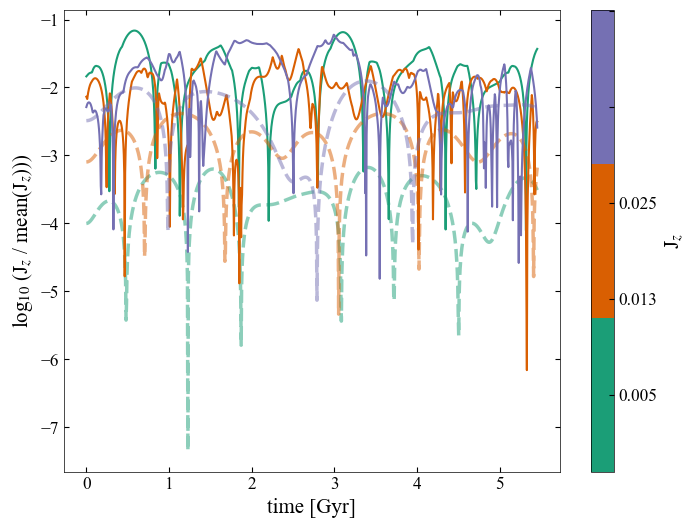

In [407]:
#plt.plot(tlist, np.log10(np.fabs((jrs.T-np.mean(jrs, axis=1))/np.mean(jrs, axis=1))))

import matplotlib.cm as cm
cmap = ListedColormap(cm.get_cmap('Dark2')(np.linspace(0, 0.25, n_actions//3)))
for i in range(n_actions//3):
    plt.plot(tlist, np.log10(np.abs((jrs[i*3].T-np.mean(jrs[i*3], axis=0))/np.mean(jrs[i*3], axis=0))), c=cmap(i), linestyle='--', alpha=0.5, lw=2.5)
    plt.plot(tlist, torch.log10(torch.abs((nf_jrs[i*3].T-torch.mean(nf_jrs[i*3], axis=0))/torch.mean(nf_jrs[i*3], axis=0))).detach(), c=cmap(i), lw=1.5)

# Add a discrete colorbar
ax = plt.gca() # Get current axes
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=jrs.T[0].min(), vmax=jrs.T[0].max()))
sm._A = []  # Hack to fix a bug in ScalarMappable
cbar = plt.colorbar(sm, ax=ax)
#cbar.set_ticks(jrs.T[0][::3])
cbar.set_ticklabels([f'{i:.3f}' for i in jrs.T[0][::3]])
cbar.set_label('J$_z$', fontsize=15)
plt.xlabel('time [Gyr]', fontsize=15)
plt.ylabel('log$_{10}$ (J$_z$ / mean(J$_z$)))', fontsize=15)

In [ ]:
model.ps_to_aa()

Note! The parameter space you initilize might not be the parameter space you end up exploring

In [104]:
model.targetPotential

functools.partial(<function MWPotential2014 at 0x171bb3ba0>, R=1.0)

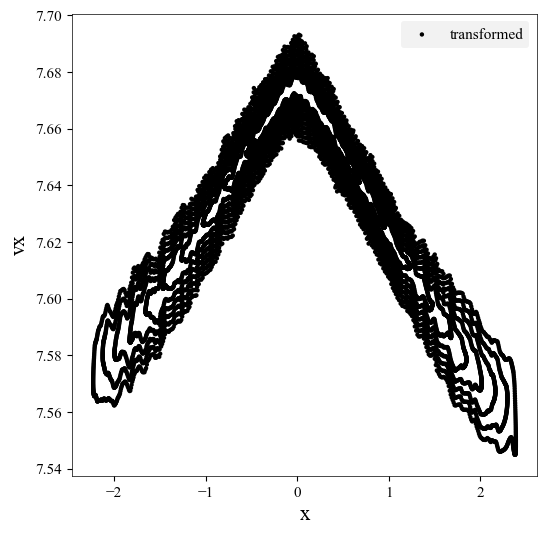

In [105]:
# plot energy for transformed orbits (with NF) and without (pre-training)
plt.figure(figsize=(6,6))
#plt.scatter(*training_ps.T, s=10, label='SHO orbit')
plt.scatter(*model.flow(training_ps).T.detach(), s=10, label='transformed')
plt.xlabel('x', fontsize=15)
plt.ylabel('vx', fontsize=15)
plt.legend()
plt.show()

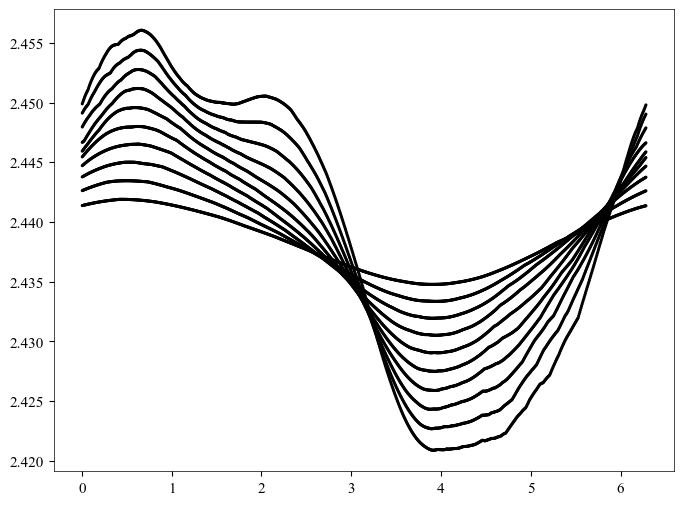

In [36]:
plt.scatter(training_aa[...,0], model.hamiltonian(training_aa).detach(), s=5, label='post-training')